In [225]:
import yfinance as yf
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from finta import TA
import numpy as np
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.metrics import jaccard_score
import seaborn as sn
from tabulate import tabulate
from xgboost import XGBClassifier
from ta import add_all_ta_features
from sklearn.feature_selection import RFE

In [226]:
WINDOW = 8 # number of rows to look ahead to see what the price did
FETCH_INTERVAL = "60m"  # fetch data by interval (including intraday if period < 60 days)
        # valid intervals: 1m,2m,5m,15m,30m,60m,90m,1h,1d,5d,1wk,1mo,3mo
        # (optional, default is '1d')
INTERVAL = '1y'     # use "period" instead of start/end
        # valid periods: 1d,5d,1mo,3mo,6mo,1y,2y,5y,10y,ytd,max
        # (optional, default is '1mo')
symbol = 'AAPL'      # Symbol of the desired stock
ROWS_TO_PREDICT = 512
# one day 16 rows of data

In [227]:
data = pd.read_csv('C:\\Users\\exomat\\Desktop\\repo\\magisterka_analiza\\data\\preprocess\\APPLE_22_03_2021 21_56_34.csv')


In [228]:
data.rename(columns={"Close": 'close', "High": 'high', "Low": 'low', 'Volume': 'volume', 'Open': 'open'}, inplace=True)
data.head(10)

,open,high,low,close,Adj Close,volume
0,56.220000,56.220000,55.500000,55.600000,55.600000,0
1,55.550000,56.095000,55.370000,55.700000,55.700000,0
2,56.032500,56.437500,55.937500,56.247500,56.247500,0
3,56.132500,56.750000,56.042500,56.595000,56.595000,0
4,56.550000,58.197500,55.625000,57.812500,57.812500,0
5,57.837500,59.525000,56.887500,57.020000,57.020000,0
6,56.299999,56.750000,54.823750,55.450001,55.450001,21473989
7,55.465000,55.889999,53.412498,53.767502,53.767502,11306818
8,53.762501,55.097500,53.152500,54.803925,54.803925,11355189
9,54.823875,56.775002,54.472500,55.486252,55.486252,10671797


<AxesSubplot:>

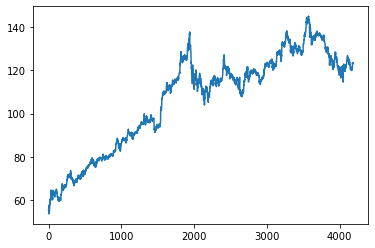

In [229]:
data['close'].plot()

In [230]:
data['close_pct'] = data['close'].pct_change();
data.head()

,open,high,low,close,Adj Close,volume,close_pct
0,56.2200,56.2200,55.5000,55.6000,55.6000,0,NaN
1,55.5500,56.0950,55.3700,55.7000,55.7000,0,0.001799
2,56.0325,56.4375,55.9375,56.2475,56.2475,0,0.009829
3,56.1325,56.7500,56.0425,56.5950,56.5950,0,0.006178
4,56.5500,58.1975,55.6250,57.8125,57.8125,0,0.021513


In [231]:
data.describe()

,open,high,low,close,Adj Close,volume,close_pct
count,4183.000000,4183.000000,4183.000000,4183.000000,4183.000000,4.183000e+03,4182.000000
mean,106.643887,107.166827,106.048708,106.644971,106.644971,4.714023e+06,0.000208
std,22.417863,23.119607,22.318330,22.402033,22.402033,8.307361e+06,0.005948
min,53.762501,55.097500,50.978220,53.767502,53.767502,0.000000e+00,-0.051319
25%,88.078750,88.337500,87.816251,88.085000,88.085000,0.000000e+00,-0.002029
50%,114.907500,115.240000,114.200000,114.900000,114.900000,0.000000e+00,0.000164
75%,123.514999,124.200000,122.829999,123.482502,123.482502,7.035940e+06,0.002525
max,144.900000,438.440000,144.590000,144.910000,144.910000,9.845401e+07,0.051457


In [232]:
def _get_indicator_data(data):
    """
    Function that uses the finta API to calculate technical indicators used as the features
    :return:
    """


    data = add_all_ta_features(
    data, open="open", high="high", low="low", close="close", volume="volume", fillna=True)

    # Instead of using the actual volume value (which changes over time), we normalize it with a moving volume average
    # data['normVol'] = data['volume'] / data['volume'].ewm(5).mean()
    # for i in range(1,50):
    #     data[f'close{i}'] = data['close'].shift(i)
    # Remove columns that won't be used as features
    del (data['open'])
    del (data['high'])
    del (data['low'])
    # del (data['volume'])
    del (data['Adj Close'])

    return data

data = _get_indicator_data(data)

C:\Users\exomat\anaconda3\envs\magisterka_analiza\lib\site-packages\ta\trend.py:768: RuntimeWarning: invalid value encountered in double_scalars
  dip[i] = 100 * (self._dip[i] / self._trs[i])
C:\Users\exomat\anaconda3\envs\magisterka_analiza\lib\site-packages\ta\trend.py:772: RuntimeWarning: invalid value encountered in double_scalars
  din[i] = 100 * (self._din[i] / self._trs[i])


In [233]:
data

,close,volume,close_pct,volume_adi,volume_obv,volume_cmf,volume_fi,volume_mfi,volume_em,volume_sma_em,...,momentum_wr,momentum_ao,momentum_kama,momentum_roc,momentum_ppo,momentum_ppo_signal,momentum_ppo_hist,others_dr,others_dlr,others_cr
0,55.600000,0,NaN,-0.000000e+00,0,0.000000,0.000000e+00,50.000000,0.000000,0.000000,...,-86.111111,0.000000,55.600000,0.000000,0.000000,0.000000,0.000000,-47.864396,0.000000,0.000000
1,55.700000,0,0.001799,-0.000000e+00,0,0.000000,0.000000e+00,50.000000,0.000000,0.000000,...,-61.176471,0.000000,55.641486,0.000000,0.000000,0.000000,0.000000,0.179856,0.179695,0.179856
2,56.247500,0,0.009829,0.000000e+00,0,0.000000,0.000000e+00,50.000000,0.000000,0.000000,...,-17.798595,0.000000,55.895109,0.000000,0.000000,0.000000,0.000000,0.982944,0.978145,1.164568
3,56.595000,0,0.006178,0.000000e+00,0,0.000000,0.000000e+00,50.000000,0.000000,0.000000,...,-11.231884,0.000000,56.185689,0.000000,0.000000,0.000000,0.000000,0.617805,0.615905,1.789568
4,57.812500,0,0.021513,0.000000e+00,0,0.000000,0.000000e+00,50.000000,0.000000,0.000000,...,-13.616269,0.000000,56.833695,0.000000,0.000000,0.000000,0.000000,2.151250,2.128437,3.979317
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4178,123.091103,12373575,-0.002746,6.772166e+08,-304635341,-0.032093,3.952908e+06,100.000000,3.539772,5.152305,...,-5.788523,1.307150,122.417025,2.550281,17.274375,-5.237322,22.511697,-0.274567,-0.274944,121.386875
4179,123.542000,9430925,0.003663,6.814015e+08,-295204416,0.073995,3.995690e+06,100.000000,-0.033912,4.115061,...,-1.943993,1.853018,122.683125,2.960247,17.006940,-0.788469,17.795410,0.366312,0.365642,122.197841
4180,123.345001,11354023,-0.001595,6.727190e+08,-306558439,-0.022353,3.105345e+06,100.000000,0.903980,3.579881,...,-13.392887,2.216141,122.806622,2.770373,18.299709,3.029166,15.270543,-0.159459,-0.159586,121.843527
4181,123.370003,10684835,0.000203,6.749298e+08,-295873604,0.039436,2.699886e+06,88.424942,-1.424946,2.864906,...,-12.755093,2.310367,122.908690,2.119032,18.355886,6.094510,12.261375,0.020270,0.020268,121.888494


In [234]:
data.columns

Index(['close', 'volume', 'close_pct', 'volume_adi', 'volume_obv',
       'volume_cmf', 'volume_fi', 'volume_mfi', 'volume_em', 'volume_sma_em',
       'volume_vpt', 'volume_nvi', 'volume_vwap', 'volatility_atr',
       'volatility_bbm', 'volatility_bbh', 'volatility_bbl', 'volatility_bbw',
       'volatility_bbp', 'volatility_bbhi', 'volatility_bbli',
       'volatility_kcc', 'volatility_kch', 'volatility_kcl', 'volatility_kcw',
       'volatility_kcp', 'volatility_kchi', 'volatility_kcli',
       'volatility_dcl', 'volatility_dch', 'volatility_dcm', 'volatility_dcw',
       'volatility_dcp', 'volatility_ui', 'trend_macd', 'trend_macd_signal',
       'trend_macd_diff', 'trend_sma_fast', 'trend_sma_slow', 'trend_ema_fast',
       'trend_ema_slow', 'trend_adx', 'trend_adx_pos', 'trend_adx_neg',
       'trend_vortex_ind_pos', 'trend_vortex_ind_neg', 'trend_vortex_ind_diff',
       'trend_trix', 'trend_mass_index', 'trend_cci', 'trend_dpo', 'trend_kst',
       'trend_kst_sig', 'trend_kst_

In [235]:
def create_class_column(row):
    if row['close_shift']-row['close'] > 1.5:
        return 1
    if row['close_shift'] -row['close']< -1.5:
        return -1
    else:
        return 0

In [236]:
data['close_shift'] = data.shift(-WINDOW)['close']
data

,close,volume,close_pct,volume_adi,volume_obv,volume_cmf,volume_fi,volume_mfi,volume_em,volume_sma_em,...,momentum_ao,momentum_kama,momentum_roc,momentum_ppo,momentum_ppo_signal,momentum_ppo_hist,others_dr,others_dlr,others_cr,close_shift
0,55.600000,0,NaN,-0.000000e+00,0,0.000000,0.000000e+00,50.000000,0.000000,0.000000,...,0.000000,55.600000,0.000000,0.000000,0.000000,0.000000,-47.864396,0.000000,0.000000,54.803925
1,55.700000,0,0.001799,-0.000000e+00,0,0.000000,0.000000e+00,50.000000,0.000000,0.000000,...,0.000000,55.641486,0.000000,0.000000,0.000000,0.000000,0.179856,0.179695,0.179856,55.486252
2,56.247500,0,0.009829,0.000000e+00,0,0.000000,0.000000e+00,50.000000,0.000000,0.000000,...,0.000000,55.895109,0.000000,0.000000,0.000000,0.000000,0.982944,0.978145,1.164568,55.264999
3,56.595000,0,0.006178,0.000000e+00,0,0.000000,0.000000e+00,50.000000,0.000000,0.000000,...,0.000000,56.185689,0.000000,0.000000,0.000000,0.000000,0.617805,0.615905,1.789568,54.432499
4,57.812500,0,0.021513,0.000000e+00,0,0.000000,0.000000e+00,50.000000,0.000000,0.000000,...,0.000000,56.833695,0.000000,0.000000,0.000000,0.000000,2.151250,2.128437,3.979317,55.994999
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4178,123.091103,12373575,-0.002746,6.772166e+08,-304635341,-0.032093,3.952908e+06,100.000000,3.539772,5.152305,...,1.307150,122.417025,2.550281,17.274375,-5.237322,22.511697,-0.274567,-0.274944,121.386875,NaN
4179,123.542000,9430925,0.003663,6.814015e+08,-295204416,0.073995,3.995690e+06,100.000000,-0.033912,4.115061,...,1.853018,122.683125,2.960247,17.006940,-0.788469,17.795410,0.366312,0.365642,122.197841,NaN
4180,123.345001,11354023,-0.001595,6.727190e+08,-306558439,-0.022353,3.105345e+06,100.000000,0.903980,3.579881,...,2.216141,122.806622,2.770373,18.299709,3.029166,15.270543,-0.159459,-0.159586,121.843527,NaN
4181,123.370003,10684835,0.000203,6.749298e+08,-295873604,0.039436,2.699886e+06,88.424942,-1.424946,2.864906,...,2.310367,122.908690,2.119032,18.355886,6.094510,12.261375,0.020270,0.020268,121.888494,NaN


In [237]:
data['class_column'] = data.apply(create_class_column, axis=1)
data

,close,volume,close_pct,volume_adi,volume_obv,volume_cmf,volume_fi,volume_mfi,volume_em,volume_sma_em,...,momentum_kama,momentum_roc,momentum_ppo,momentum_ppo_signal,momentum_ppo_hist,others_dr,others_dlr,others_cr,close_shift,class_column
0,55.600000,0,NaN,-0.000000e+00,0,0.000000,0.000000e+00,50.000000,0.000000,0.000000,...,55.600000,0.000000,0.000000,0.000000,0.000000,-47.864396,0.000000,0.000000,54.803925,0
1,55.700000,0,0.001799,-0.000000e+00,0,0.000000,0.000000e+00,50.000000,0.000000,0.000000,...,55.641486,0.000000,0.000000,0.000000,0.000000,0.179856,0.179695,0.179856,55.486252,0
2,56.247500,0,0.009829,0.000000e+00,0,0.000000,0.000000e+00,50.000000,0.000000,0.000000,...,55.895109,0.000000,0.000000,0.000000,0.000000,0.982944,0.978145,1.164568,55.264999,0
3,56.595000,0,0.006178,0.000000e+00,0,0.000000,0.000000e+00,50.000000,0.000000,0.000000,...,56.185689,0.000000,0.000000,0.000000,0.000000,0.617805,0.615905,1.789568,54.432499,-1
4,57.812500,0,0.021513,0.000000e+00,0,0.000000,0.000000e+00,50.000000,0.000000,0.000000,...,56.833695,0.000000,0.000000,0.000000,0.000000,2.151250,2.128437,3.979317,55.994999,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4178,123.091103,12373575,-0.002746,6.772166e+08,-304635341,-0.032093,3.952908e+06,100.000000,3.539772,5.152305,...,122.417025,2.550281,17.274375,-5.237322,22.511697,-0.274567,-0.274944,121.386875,NaN,0
4179,123.542000,9430925,0.003663,6.814015e+08,-295204416,0.073995,3.995690e+06,100.000000,-0.033912,4.115061,...,122.683125,2.960247,17.006940,-0.788469,17.795410,0.366312,0.365642,122.197841,NaN,0
4180,123.345001,11354023,-0.001595,6.727190e+08,-306558439,-0.022353,3.105345e+06,100.000000,0.903980,3.579881,...,122.806622,2.770373,18.299709,3.029166,15.270543,-0.159459,-0.159586,121.843527,NaN,0
4181,123.370003,10684835,0.000203,6.749298e+08,-295873604,0.039436,2.699886e+06,88.424942,-1.424946,2.864906,...,122.908690,2.119032,18.355886,6.094510,12.261375,0.020270,0.020268,121.888494,NaN,0


In [238]:
# Class divide
data['class_column'].value_counts()

 0    2935
 1     700
-1     548
Name: class_column, dtype: int64

In [239]:
del (data['close'])
del (data['close_shift'])
data = data.dropna()
train_set = data.iloc[:-ROWS_TO_PREDICT]
train_set = train_set.iloc[:-WINDOW] # optional drop last n rows (avoid of data leak)
test_set =data.iloc[-ROWS_TO_PREDICT:]

In [240]:
data['class_column'].value_counts()

 0    2934
 1     700
-1     548
Name: class_column, dtype: int64

In [241]:
train_set

,volume,close_pct,volume_adi,volume_obv,volume_cmf,volume_fi,volume_mfi,volume_em,volume_sma_em,volume_vpt,...,momentum_ao,momentum_kama,momentum_roc,momentum_ppo,momentum_ppo_signal,momentum_ppo_hist,others_dr,others_dlr,others_cr,class_column
1,0,0.001799,-0.000000e+00,0,0.000000,0.000000e+00,50.000000,0.000000,0.000000,0.000000,...,0.000000,55.641486,0.000000,0.000000,0.000000,0.000000,0.179856,0.179695,0.179856,0
2,0,0.009829,0.000000e+00,0,0.000000,0.000000e+00,50.000000,0.000000,0.000000,0.000000,...,0.000000,55.895109,0.000000,0.000000,0.000000,0.000000,0.982944,0.978145,1.164568,0
3,0,0.006178,0.000000e+00,0,0.000000,0.000000e+00,50.000000,0.000000,0.000000,0.000000,...,0.000000,56.185689,0.000000,0.000000,0.000000,0.000000,0.617805,0.615905,1.789568,-1
4,0,0.021513,0.000000e+00,0,0.000000,0.000000e+00,50.000000,0.000000,0.000000,0.000000,...,0.000000,56.833695,0.000000,0.000000,0.000000,0.000000,2.151250,2.128437,3.979317,-1
5,0,-0.013708,0.000000e+00,0,0.000000,0.000000e+00,50.000000,0.000000,0.000000,0.000000,...,0.137792,56.907320,0.000000,0.000000,0.000000,0.000000,-1.370811,-1.380293,2.553957,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3658,23429741,-0.014937,7.974509e+08,304999887,-0.363235,-6.958348e+06,29.529642,-6.499420,-1.211784,-349979.662730,...,0.425876,134.949260,-0.954019,1.352799,-27.139769,28.492568,-1.493741,-1.505010,140.596222,1
3659,10558612,0.002231,7.968458e+08,315558499,-0.333381,-5.514037e+06,27.706281,-4.442275,-2.050300,-326418.389283,...,0.060714,134.917413,-0.655770,9.510896,-19.809636,29.320532,0.223147,0.222899,141.133107,1
3660,7608849,0.005408,8.007158e+08,323167348,-0.278061,-3.938268e+06,28.623955,6.212542,-0.677192,64706.537582,...,-0.172536,134.916251,-0.137056,11.109264,-13.625856,24.735120,0.540755,0.539299,142.437047,0
3661,11014699,0.001410,7.974242e+08,334182047,-0.279866,-3.076684e+06,45.230036,4.857641,0.418325,56671.208938,...,-0.276007,134.916574,-0.025922,16.201586,-7.660367,23.861953,0.140957,0.140857,142.778778,0


In [242]:
y = data['class_column']
features = [x for x in data.columns if x not in ['class_column']]
x = data[features]
scaler = MinMaxScaler()
# x = pd.DataFrame(scaler.fit_transform(x.values), columns=x.columns, index=x.index)
x_train= x.iloc[:-ROWS_TO_PREDICT]
y_train= y.iloc[:-ROWS_TO_PREDICT]
x_test =x.iloc[-ROWS_TO_PREDICT:]
y_test=y.iloc[-ROWS_TO_PREDICT:]

In [243]:
classifier = GradientBoostingClassifier(n_estimators=100,random_state=0,criterion='friedman_mse',max_depth=3, learning_rate=0.1)

In [244]:
def print_conf_matrix(test_y, predict, name):
    matrix = confusion_matrix(test_y, predict,  labels=[-1, 0, 1])
    print(matrix)
    ax= plt.subplot()
    sn.heatmap(matrix, annot=True, ax = ax) #annot=True to annotate cells

    # labels, title and ticks
    ax.set_xlabel('Predicted labels', color='white')
    ax.set_ylabel('True labels', color='white')
    ax.set_title(f'Confusion Matrix for {name}' , color='white')
    ax.xaxis.set_ticklabels(['-1','0', '1'], color='white')
    ax.yaxis.set_ticklabels(['-1','0', '1'], color='white')
    plt.show()

def train_model(model,train_x, train_y):
    model.fit(train_x, train_y)

Score:  0.626953125
[[  1 104   2]
 [  7 311  10]
 [  1  67   9]]


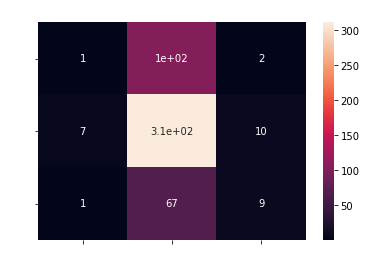

In [245]:
predictions= dict()

train_model(classifier,x_train,y_train)
predictions = classifier.predict(x_test)
score = accuracy_score(y_test.values, predictions)
print('Score: ',  score )
print_conf_matrix(y_test, predictions, "Random forest ")
